In [65]:
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [84]:
def Load_TrainData(path):
    train = {}
    for root, dirs, files in os.walk(path):
        for filename in files:
            string_filename = str(filename)
            if string_filename.find("tiff") != -1:
                train[string_filename] = [[]]
    return train

def Load_Img(Img_Path='YM.SU3.60.tiff'):
  
  img = Image.open(Img_Path)
  img.show()
  return img

In [85]:
def Crop_Img(Img, Dim_Tuple=(70,90,184,230)):
  
  cropped_img = Img.crop(Dim_Tuple)
  imgarray = np.array(cropped_img)

  print(imgarray.shape)
  print(imgarray)
  
  return imgarray

In [86]:
def Display_Img(imgarray):
  img = Image.fromarray(imgarray)
  imgplot = plt.imshow(img)
  plt.show()

In [87]:
def mean(Img, i,j, N):
  
  a=int((N-1)/2)
  u=0
  
  valid_cnt = 0
  for k in range(-a,a):
    for h in range(-a,a):
      if((k+i)>0 and (k+i)<Img.shape[0] and (h+j)>0 and (h+j)<Img.shape[1]):
        u=u+Img[k+i][h+j]
        valid_cnt = valid_cnt + 1

  u=np.float128(u/(valid_cnt*valid_cnt))
  return u

In [88]:
def st_dev(Img, i,j, N):
  
  a=int((N-1)/2)
  sd=0
    
  valid_cnt = 0
  for k in range(-a,a):
    for h in range(-a,a):
      if((k+i)>0 and (k+i)<Img.shape[0] and (h+j)>0 and (h+j)<Img.shape[1]):
        m=mean(Img, i,j, N)
        sd=sd+np.square(Img[k+i][h+j]-m)
        valid_cnt = valid_cnt + 1
        
  sd=np.float128(sd/(valid_cnt*valid_cnt))
  sd=np.sqrt(sd)
  
  return sd

In [89]:
def normalize(Img, N=11):
  
  Normalized_Img = np.zeros(Img.shape)
  
  for i in range(0,Img.shape[0]):
    for j in range(0,Img.shape[1]):
    
      print("index",i,j)
      m=mean(Img, i,j, N) 
      sd=st_dev(Img, i,j, N)
      print("mean std",m, sd)
      
      Normalized_Img[i][j]=np.float128((Img[i][j]-m)/(6*sd))
      
  return Normalized_Img

In [ ]:
def Process_Train_Set(Train_DataSet, Normalisation_Window=11, FeatureDetection_Window=11):
  
  # Assuming Train_Img_DataSet is dictioanry with Key is Image name and value is 2_D aaray with pixel values
  Images_Data = {}
  
  for Train_Img in Train_DataSet.keys():
    
    # Load train image
    Img = Load_Img(Train_Img)
    
    # Crop the train image
    Cropped_Img = Crop_Img(Img, (70,90,184,230))
    
    # Normalize train image
    Normalized_Img = normalize(Cropped_Img, Normalisation_Window)
    
    # Extract image from normalized image
    Feature_Detection_Img = normalize(Normalized_Img, FeatureDetection_Window)
    
    # Store Feature_Detection_Img to an array of dimension Train_Set_len * No_Img_Rows * No_Img_Cols
    Images_Data[Train_Img] = Feature_Detection_Img
    
    return Images_Data

In [ ]:
def Min_Max_Classifer(Train_DataSet, Test_Image_Path, Normalisation_Window=11, FeatureDetection_Window=11, alpha=3):
  
  # Pre-process train images
  Images_Data = Process_Train_Set(Train_DataSet, Normalisation_Window, FeatureDetection_Window)
  
  # Pre-Process Test Image Load -> Crop -> Normalize -> Feature Detection
  Img = Load_Img(Test_Image_Path)
  Cropped_Img = Crop_Img(Img, (70,90,184,230))
  Normalized_Img = normalize(Cropped_Img, Normalisation_Window)
  Feature_Detection_Img = normalize(Normalized_Img, FeatureDetection_Window)
  
  # Determine Min_Max Distance of test image from each train image
  
  Max_Similarity = 0
  Label_Image = ""
  
  for Train_Img in Train_DataSet.keys():
    
    Train_Img_Data = Train_DataSet[Train_Img]
    Test_Img_Data = Feature_Detection_Img
    
    # Calculate pixel wise minimum and maximum bet train and test image
    Pixel_Min = np.minimum(Train_Img_Data, Test_Img_Data)
    Pixel_Max = np.maximum(Train_Img_Data, Test_Img_Data)
    
    # Calculate pixel wise Min-Max Similarity
    Min_Max_ratio = np.divide(Pixel_Min, Pixel_Max)
    Min_Max_Sim = np.power(Min_Max_ratio, alpha)
    
    # Calculate total Min-Max Similarity
    Total_Similarity = np.sum(Min_Max_Sim)
    
    # Update Most similar train image and its similarity with test image
    if Total_Similarity > Max_Similarity:
      Max_Similarity = Total_Similarity 
      Label_Image = Train_Img
      
  # Extract emotion from image name
  Emotion_Label = Extract_Img_Label(Label_Image)
  return Emotion_Label

In [91]:
DatasetPath = os.getcwd() + "/ml-face-jaffe-dataset-master/dataset"
train = Load_TrainData(DatasetPath)

for ImagePath in train:
    path = DatasetPath + "/" + ImagePath
    Img = Load_Img(path)

imgplot = plt.imshow(Img)
plt.show()

Cropped_Img = Crop_Img(Img)
Display_Img(Cropped_Img)

{'NM.NE3.94.tiff': [[]], 'NA.SA1.205.tiff': [[]], 'TM.HA3.182.tiff': [[]], 'YM.SA3.57.tiff': [[]], 'NM.FE1.110.tiff': [[]], 'KR.SA3.79.tiff': [[]], 'KR.AN3.85.tiff': [[]], 'UY.DI1.149.tiff': [[]], 'MK.SU1.122.tiff': [[]], 'KL.FE1.174.tiff': [[]], 'KL.HA2.159.tiff': [[]], 'KR.SA2.78.tiff': [[]], 'UY.DI2.150.tiff': [[]], 'MK.HA1.116.tiff': [[]], 'YM.DI2.65.tiff': [[]], 'KR.HA2.75.tiff': [[]], 'KA.SA2.34.tiff': [[]], 'KA.DI2.43.tiff': [[]], 'KR.AN2.84.tiff': [[]], 'KL.SU3.166.tiff': [[]], 'MK.SA2.120.tiff': [[]], 'KR.SA1.77.tiff': [[]], 'UY.FE1.152.tiff': [[]], 'KM.AN3.19.tiff': [[]], 'KA.SA1.33.tiff': [[]], 'MK.SU3.124.tiff': [[]], 'NM.AN2.105.tiff': [[]], 'NM.SA2.99.tiff': [[]], 'KL.SU2.165.tiff': [[]], 'KA.HA1.29.tiff': [[]], 'YM.FE2.68.tiff': [[]], 'KL.AN1.167.tiff': [[]], 'YM.SU3.60.tiff': [[]], 'KL.DI4.173.tiff': [[]], 'YM.AN3.63.tiff': [[]], 'KA.SA3.35.tiff': [[]], 'KA.SU2.37.tiff': [[]], 'MK.DI3.130.tiff': [[]], 'NA.AN2.212.tiff': [[]], 'YM.DI3.66.tiff': [[]], 'YM.SU2.59.tiff': [[

In [67]:
Normalized_Img = normalize(Cropped_Img, 11)

index 0 0
mean std 2.76171875 12.097579034467112034
index 0 1
mean std 2.7000000000000001776 13.278347035681813323
index 0 2
mean std 2.625 14.152282832638697657
index 0 3
mean std 2.5382653061224491609 14.75558101881613563
index 0 4
mean std 2.4482421875 15.1611563626166355725
index 0 5
mean std 2.3549382716049382935 15.407407209903471172
index 0 6
mean std 2.2331249999999998046 15.294740980166699961
index 0 7
mean std 2.4968750000000001776 16.374071426737170067
index 0 8
mean std 2.65625 16.97439434785708341
index 0 9
mean std 2.705000000000000071 17.236230029359668523
index 0 10
mean std 2.7462499999999998579 17.480124973854234454
index 0 11
mean std 2.7406250000000000888 17.496073841108342342
index 0 12
mean std 2.6549999999999998046 17.127556031874483434
index 0 13
mean std 2.5393750000000001599 16.56592843318827163
index 0 14
mean std 2.4087499999999999467 15.841627087804538402
index 0 15
mean std 2.2512500000000001954 14.939267051601376978
index 0 16
mean std 2.12625000000000019

Normalized Image array:  [[0.08594393 0.17949021 0.16928953 ... 0.87920997 0.8963471  0.67223026]
 [0.01092918 0.11803103 0.23941879 ... 0.893237   1.00023159 0.78900388]
 [0.11091595 0.14411859 0.35492985 ... 1.01421331 1.07711274 0.85709517]
 ...
 [0.97649918 0.80891394 3.40500418 ... 1.36770138 1.28664389 1.22247764]
 [1.80955724 0.73894858 1.77560099 ... 1.11319472 1.19221823 1.09502486]
 [0.80637001 0.66677798 1.19886695 ... 1.1559991  1.10444236 1.00896093]]


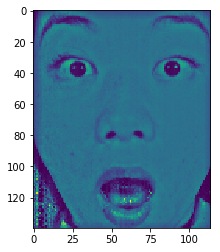

In [68]:
print("Normalized Image array: ", Normalized_Img)
Display_Img(Normalized_Img)

In [69]:
Feature_Detection_Img = normalize(Normalized_Img, 11)

index 0 0
mean std 0.036273028837729634488 0.16077187175586717155
index 0 1
mean std 0.035692363010723350547 0.17802300120054932655
index 0 2
mean std 0.035220121546460682327 0.19356614191223822881
index 0 3
mean std 0.03396177783833577435 0.20079245662515170476
index 0 4
mean std 0.032493878418330256197 0.20364991199917578066
index 0 5
mean std 0.031058079139336752794 0.20517842214284585623
index 0 6
mean std 0.02929064515482143402 0.2020998358941940269
index 0 7
mean std 0.032628785864928330773 0.21479941205072661722
index 0 8
mean std 0.034670307238018734097 0.22187539988274443
index 0 9
mean std 0.035382478431485890613 0.22509062919063941528
index 0 10
mean std 0.036293775200984257356 0.22971507223196147539
index 0 11
mean std 0.03684400427454932736 0.23278230475602434426
index 0 12
mean std 0.03617806848904674133 0.22915292195848428033
index 0 13
mean std 0.035420207520852058092 0.22482781448610371009
index 0 14
mean std 0.03474233436795926 0.22076399130108956059
index 0 15
mean s

Features detected array:  [[ 0.05149212  0.13462479  0.11543807 ...  0.60056131  0.600391
   0.42707673]
 [-0.02142024  0.08332901  0.18470088 ...  0.65155631  0.70842029
   0.5335339 ]
 [ 0.090262    0.112834    0.29504337 ...  0.79553343  0.80533707
   0.60936661]
 ...
 [ 0.64758465  0.67149365  3.41062708 ...  1.13751747  1.03125461
   0.93851981]
 [ 1.12083619  0.56120415  1.63049659 ...  0.8702731   0.90367392
   0.79563407]
 [ 0.43667558  0.45358496  0.98762231 ...  0.84601861  0.78242176
   0.68404068]]


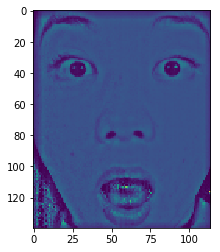

In [71]:
print("Features detected array: ", Feature_Detection_Img)
Display_Img(Feature_Detection_Img)